In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms as T
from torch.utils.data import SubsetRandomSampler as SRS
from torch.utils.data import DataLoader
from data.Dataset import Proteins
from sklearn.model_selection import train_test_split
from config import DefaultConfig
from models import resnet101
import time
import os

In [59]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [218]:
 transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
])

dataset_AB42_SYN = Proteins(root=r'C:\Users\y63qiu\PycharmProjects\Pure protein project\data\AB42-SYN LA images',transforms=transform)

# Split train and test sets 7:3
train_idx, val_test_idx = train_test_split(
    np.arange(len(dataset_AB42_SYN.labels)),
    test_size=0.3,
    stratify=dataset_AB42_SYN.labels
)

val_test_labels = [dataset_AB42_SYN.labels[i] for i in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.66, stratify=val_test_labels)

train_sampler = SRS(train_idx)
val_sampler = SRS(val_idx)
test_sampler = SRS(test_idx)

train_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=train_sampler)
val_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=val_sampler)
test_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=test_sampler)

In [219]:
dataset_AB42_SYN.labels.count(0),dataset_AB42_SYN.labels.count(1)

(184, 176)

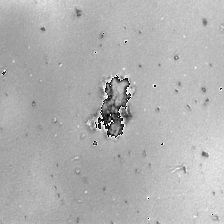

In [220]:
to_img = T.ToPILImage()
to_img(dataset_AB42_SYN[1][0])

In [221]:
import visdom
vis = visdom.Visdom(env='LA')
vis.line([0],[0], win='train_acc', opts=dict(title='train acc', legend=['train acc']))
vis.line([0],[0], win='val_acc', opts=dict(title='val acc', legend=['val acc']))
vis.line([0],[0], win='train_loss', opts=dict(title='train loss',legend=['train loss']))
vis.line([0],[0], win='val_loss', opts=dict(title='val loss', legend=['val loss']))

Setting up a new session...


'val_loss'

In [222]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, train_loader=train_loader, val_loader=val_loader):
    since = time.time()
    global_step = 0
    
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        print('Epoch {}{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                        
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)  # 1 is the dimension
                loss = criterion(outputs, labels)

                # backward + optimize
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Decay learning rate

        epoch_loss = running_loss / train_loader.sampler.indices.shape[0]
        epoch_acc = running_corrects.item() / train_loader.sampler.indices.shape[0]
        
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

        print('{} Loss: {: .4f} Acc: {: .4f}'.format(
            'Train', epoch_loss, epoch_acc
        ))
        
        # plot for visdom
        global_step += 1
        vis.line([epoch_acc],[global_step], win='train_acc', update='append')
        vis.line([epoch_loss],[global_step], win='train_loss',update='append')
        scheduler.step()
        
        # start validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            loss = criterion(outputs,labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss = val_loss/val_loader.sampler.indices.shape[0]
        epoch_val_acc = val_corrects.item()/val_loader.sampler.indices.shape[0]
        
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_acc)
        
        # visdom plot
        vis.line([epoch_val_acc], [global_step],win='val_acc', update='append')
        vis.line([epoch_val_loss],[global_step], win='val_loss', update='append')
            
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))

    # load best model weights
    return model, train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [223]:
def test(model, test_loader=test_loader):
    test_corrects = 0
    
    model.eval()
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _,preds = torch.max(outputs,1)
        
        test_corrects += torch.sum(preds == labels.data)
        
    test_acc = test_corrects.double()/test_loader.sampler.indices.shape[0]
    
    return test_corrects, test_acc

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_4 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=100)

Epoch 099
----------
Train Loss:  0.7013 Acc:  0.4841
Epoch 199
----------
Train Loss:  0.6809 Acc:  0.5714
Epoch 299
----------
Train Loss:  0.6396 Acc:  0.6786
Epoch 399
----------
Train Loss:  0.5472 Acc:  0.7341
Epoch 499
----------
Train Loss:  0.4874 Acc:  0.8016
Epoch 599
----------
Train Loss:  0.4060 Acc:  0.8532
Epoch 699
----------
Train Loss:  0.3917 Acc:  0.8175
Epoch 799
----------
Train Loss:  0.4527 Acc:  0.8413
Epoch 899
----------
Train Loss:  0.4693 Acc:  0.8532
Epoch 999
----------
Train Loss:  0.4339 Acc:  0.8175
Epoch 1099
----------
Train Loss:  0.2366 Acc:  0.9325
Epoch 1199
----------
Train Loss:  0.7607 Acc:  0.6389
Epoch 1299
----------
Train Loss:  0.5463 Acc:  0.6349
Epoch 1399
----------
Train Loss:  0.4225 Acc:  0.8254
Epoch 1499
----------
Train Loss:  0.5317 Acc:  0.7738
Epoch 1599
----------
Train Loss:  0.4242 Acc:  0.8452
Epoch 1699
----------
Train Loss:  0.3298 Acc:  0.8690
Epoch 1799
----------
Train Loss:  0.3008 Acc:  0.8968
Epoch 1899
---------

In [49]:
_,acc_test_4 = test(resnet101_AB42_SYN_4)
acc_test_4

tensor(0.8472, device='cuda:0', dtype=torch.float64)

In [50]:
_,acc_train_4 = test(resnet101_AB42_SYN_4,train_loader)
acc_train_4

tensor(1., device='cuda:0', dtype=torch.float64)

In [51]:
_, acc_val_4 = test(resnet101_AB42_SYN_4,val_loader)
acc_val_4

tensor(0.8056, device='cuda:0', dtype=torch.float64)

# Conv visualization

In [15]:
from PIL import Image

In [16]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image succesfully loaded")
    return image

def normalize(image):
    transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
])
    image = transform(image)
    image = image.cuda()
    image = image.unsqueeze(0)
    return image

def predict(image):
    output = resnet101_AB42_SYN_6(image)
    _,pred = torch.max(output,1)
    return str(pred.item()), "AB-42" if pred.item() == 1 else "Alpha-syn"

def deprocess(image):
    return image * torch.Tensor([0.5, 0.5, 0.5]).cuda()  + torch.Tensor([0.5, 0.5, 0.5]).cuda()

In [17]:
def make_saliency_map(input,model,label):
    input.requires_grad=True
    output = model.forward(input)
    output[0][label].backward()
    #grads = input.grad.data.clamp(min=0)
    grads = input.grad.data.abs()
    gradsout = grads.squeeze()
    gradsout = gradsout.transpose(0,1)
    gradsout = gradsout.transpose(1,2)
    gradsout = np.amax(gradsout.cpu().numpy(), axis=2) # return the maximum value in RGB channel
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)
    
    fig = plt.figure()
    
    plot_win = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    
    plot_win = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(gradsout)
    plt.title('Saliency map')
    
    return true_image, gradsout

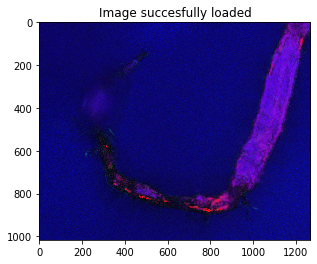

In [57]:
protein_2 = load_image("./data/AB42-SYN Combination images/(Alpha-syn)(S1)(Region 017 A)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_2)

In [58]:
predict(protein_2_normal)

('0', 'Alpha-syn')

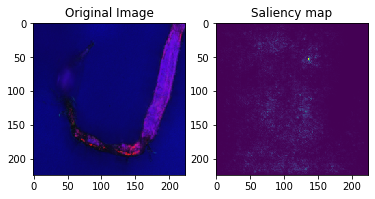

In [60]:
true,sal = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_4,0)

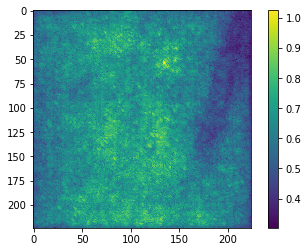

In [63]:
nout = np.power(sal, 0.1)
plt.imshow(nout)
plt.colorbar()

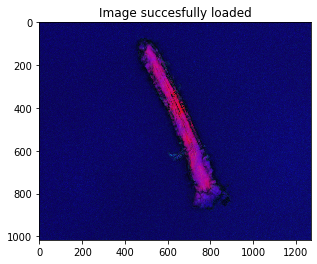

In [65]:
protein_2 = load_image("./data/AB42-SYN Combination images/(Alpha-syn)(U3)(633 Region 010)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_2)

In [66]:
predict(protein_2_normal)

('0', 'Alpha-syn')

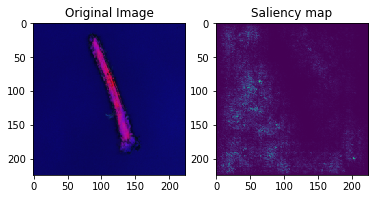

In [67]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_4,0)

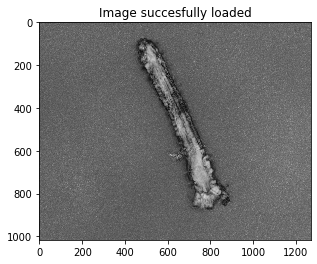

In [23]:
protein_2 = load_image("./data/AB42-SYN LA images/(Alpha-syn)(U3)(633 Region 010)(RS1)(PS1)(Anisotropy Lin).png")
protein_2_normal = normalize(protein_2)

In [26]:
predict(protein_2_normal)

('0', 'Alpha-syn')

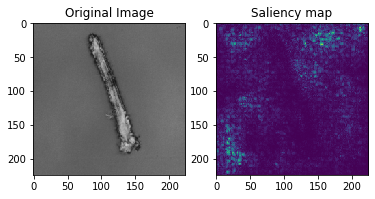

In [27]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_5,0)

(-0.5, 223.5, 223.5, -0.5)

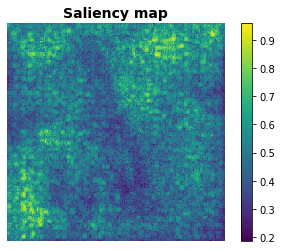

In [32]:
nout = np.power(sal_map, 0.2)

plt.imshow(nout)
plt.title('Saliency map',fontsize=14,fontweight='bold')
plt.colorbar()
plt.axis('off') 

# Train for 200 epochs

In [72]:
import visdom
vis = visdom.Visdom(env=u'protein')
vis.line([0],[0], win='train_acc', opts=dict(title='train acc', legend=['train acc']))
vis.line([0],[0], win='val_acc', opts=dict(title='val acc', legend=['val acc']))
vis.line([0],[0], win='train_loss', opts=dict(title='train loss',legend=['train loss']))
vis.line([0],[0], win='val_loss', opts=dict(title='val loss', legend=['val loss']))

Setting up a new session...


'val_loss'

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_2 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=200)

Epoch 0199
----------
Train Loss:  0.6934 Acc:  0.5000
Epoch 1199
----------
Train Loss:  0.6688 Acc:  0.6429
Epoch 2199
----------
Train Loss:  0.5792 Acc:  0.7262
Epoch 3199
----------
Train Loss:  0.5113 Acc:  0.7540
Epoch 4199
----------
Train Loss:  0.4731 Acc:  0.7659
Epoch 5199
----------
Train Loss:  0.3955 Acc:  0.8492
Epoch 6199
----------
Train Loss:  0.2405 Acc:  0.9127
Epoch 7199
----------
Train Loss:  0.3998 Acc:  0.8175
Epoch 8199
----------
Train Loss:  0.3945 Acc:  0.8690
Epoch 9199
----------
Train Loss:  0.3277 Acc:  0.8968
Epoch 10199
----------
Train Loss:  0.2070 Acc:  0.9444
Epoch 11199
----------
Train Loss:  0.2091 Acc:  0.9286
Epoch 12199
----------
Train Loss:  0.2840 Acc:  0.9048
Epoch 13199
----------
Train Loss:  0.2680 Acc:  0.9167
Epoch 14199
----------
Train Loss:  0.1226 Acc:  0.9603
Epoch 15199
----------
Train Loss:  0.1006 Acc:  0.9643
Epoch 16199
----------
Train Loss:  0.2594 Acc:  0.9087
Epoch 17199
----------
Train Loss:  0.2880 Acc:  0.8968
Ep

Epoch 146199
----------
Train Loss:  0.0145 Acc:  1.0000
Epoch 147199
----------
Train Loss:  0.0184 Acc:  0.9921
Epoch 148199
----------
Train Loss:  0.0133 Acc:  0.9960
Epoch 149199
----------
Train Loss:  0.0127 Acc:  1.0000
Epoch 150199
----------
Train Loss:  0.0535 Acc:  0.9881
Epoch 151199
----------
Train Loss:  0.0065 Acc:  1.0000
Epoch 152199
----------
Train Loss:  0.0109 Acc:  0.9960
Epoch 153199
----------
Train Loss:  0.0049 Acc:  1.0000
Epoch 154199
----------
Train Loss:  0.0208 Acc:  0.9960
Epoch 155199
----------
Train Loss:  0.0266 Acc:  0.9960
Epoch 156199
----------
Train Loss:  0.0446 Acc:  0.9841
Epoch 157199
----------
Train Loss:  0.0164 Acc:  0.9921
Epoch 158199
----------
Train Loss:  0.0060 Acc:  1.0000
Epoch 159199
----------
Train Loss:  0.0235 Acc:  0.9921
Epoch 160199
----------
Train Loss:  0.0196 Acc:  0.9960
Epoch 161199
----------
Train Loss:  0.0050 Acc:  1.0000
Epoch 162199
----------
Train Loss:  0.0070 Acc:  1.0000
Epoch 163199
----------
Train L

In [74]:
_,acc_test_2 = test(resnet101_AB42_SYN_2)
acc_test_2

tensor(0.8333, device='cuda:0', dtype=torch.float64)

In [75]:
_,acc_train_2 = test(resnet101_AB42_SYN_2,train_loader)
acc_train_2

tensor(1., device='cuda:0', dtype=torch.float64)

## Retest the LR with standardized images

In [14]:
 transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
])

dataset_AB42_SYN = Proteins(root=r'C:\Users\y63qiu\PycharmProjects\Pure protein project\data\AB42-SYN images',transforms=transform)

# Split train and test sets 7:3
train_idx, val_test_idx = train_test_split(
    np.arange(len(dataset_AB42_SYN.labels)),
    test_size=0.3,
    stratify=dataset_AB42_SYN.labels
)

val_test_labels = [dataset_AB42_SYN.labels[i] for i in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.66, stratify=val_test_labels)

train_sampler = SRS(train_idx)
val_sampler = SRS(val_idx)
test_sampler = SRS(test_idx)

train_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=train_sampler)
val_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=val_sampler)
test_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=test_sampler)

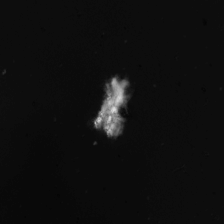

In [16]:
to_img = T.ToPILImage()
to_img(dataset_AB42_SYN[1][0])

In [17]:
import visdom
vis = visdom.Visdom(env='ST LR')
vis.line([0],[0], win='train_acc_LR', opts=dict(title='train acc', legend=['train acc']))
vis.line([0],[0], win='val_acc_LR', opts=dict(title='val acc', legend=['val acc']))
vis.line([0],[0], win='train_loss_LR', opts=dict(title='train loss',legend=['train loss']))
vis.line([0],[0], win='val_loss_LR', opts=dict(title='val loss', legend=['val loss']))

Setting up a new session...


'val_loss_LR'

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
#model_AB42_SYN.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_3 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=100)

Epoch 099
----------
Train Loss:  0.6967 Acc:  0.5119
Epoch 199
----------
Train Loss:  0.6969 Acc:  0.5000
Epoch 299
----------
Train Loss:  0.6900 Acc:  0.5397
Epoch 399
----------
Train Loss:  0.6641 Acc:  0.6032
Epoch 499
----------
Train Loss:  0.5816 Acc:  0.7143
Epoch 599
----------
Train Loss:  0.4852 Acc:  0.7738
Epoch 699
----------
Train Loss:  0.4420 Acc:  0.8095
Epoch 799
----------
Train Loss:  0.4464 Acc:  0.7579
Epoch 899
----------
Train Loss:  0.5855 Acc:  0.7143
Epoch 999
----------
Train Loss:  0.4965 Acc:  0.7738
Epoch 1099
----------
Train Loss:  0.4316 Acc:  0.8294
Epoch 1199
----------
Train Loss:  0.3894 Acc:  0.8730
Epoch 1299
----------
Train Loss:  0.2064 Acc:  0.9246
Epoch 1399
----------
Train Loss:  0.3567 Acc:  0.8373
Epoch 1499
----------
Train Loss:  0.2104 Acc:  0.9325
Epoch 1599
----------
Train Loss:  0.1354 Acc:  0.9405
Epoch 1699
----------
Train Loss:  0.1852 Acc:  0.9286
Epoch 1799
----------
Train Loss:  0.2138 Acc:  0.9206
Epoch 1899
---------

In [19]:
_,acc_test_3 = test(resnet101_AB42_SYN_3)
acc_test_3

tensor(0.8889, device='cuda:0', dtype=torch.float64)

In [13]:
_,acc_train_3 = test(resnet101_AB42_SYN_3,train_loader)
acc_train_3

tensor(1., device='cuda:0', dtype=torch.float64)

# LA images 

In [224]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_5, train_acc_LA, train_loss_LA, test_acc_LA, test_loss_LA = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=100)

Epoch 099
----------
Train Loss:  0.6937 Acc:  0.5119
Epoch 199
----------
Train Loss:  0.6746 Acc:  0.5952
Epoch 299
----------
Train Loss:  0.5705 Acc:  0.7183
Epoch 399
----------
Train Loss:  0.4974 Acc:  0.7976
Epoch 499
----------
Train Loss:  0.6829 Acc:  0.6151
Epoch 599
----------
Train Loss:  0.5266 Acc:  0.7937
Epoch 699
----------
Train Loss:  0.6327 Acc:  0.6190
Epoch 799
----------
Train Loss:  0.4522 Acc:  0.8373
Epoch 899
----------
Train Loss:  0.3904 Acc:  0.8492
Epoch 999
----------
Train Loss:  0.3248 Acc:  0.8849
Epoch 1099
----------
Train Loss:  0.2926 Acc:  0.8849
Epoch 1199
----------
Train Loss:  0.3774 Acc:  0.8532
Epoch 1299
----------
Train Loss:  0.2490 Acc:  0.9127
Epoch 1399
----------
Train Loss:  0.2632 Acc:  0.9048
Epoch 1499
----------
Train Loss:  0.2535 Acc:  0.9167
Epoch 1599
----------
Train Loss:  0.1980 Acc:  0.9246
Epoch 1699
----------
Train Loss:  0.1487 Acc:  0.9484
Epoch 1799
----------
Train Loss:  0.3321 Acc:  0.8849
Epoch 1899
---------

In [225]:
_,acc_test_5 = test(resnet101_AB42_SYN_5)
acc_test_5

tensor(0.8333, device='cuda:0', dtype=torch.float64)

In [226]:
_,acc_train_5 = test(resnet101_AB42_SYN_5,train_loader)
acc_train_5

tensor(1., device='cuda:0', dtype=torch.float64)

# LR images

In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_1, train_acc_LR, train_loss_LR, test_acc_LR, test_loss_LR = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=100)

Epoch 099
----------
Train Loss:  0.6940 Acc:  0.5040
Epoch 199
----------
Train Loss:  0.6757 Acc:  0.5833
Epoch 299
----------
Train Loss:  0.6444 Acc:  0.6111
Epoch 399
----------
Train Loss:  0.7230 Acc:  0.5317
Epoch 499
----------
Train Loss:  0.6220 Acc:  0.6706
Epoch 599
----------
Train Loss:  0.4586 Acc:  0.8056
Epoch 699
----------
Train Loss:  0.5762 Acc:  0.7460
Epoch 799
----------
Train Loss:  0.4353 Acc:  0.7857
Epoch 899
----------
Train Loss:  0.3899 Acc:  0.8333
Epoch 999
----------
Train Loss:  0.5369 Acc:  0.7619
Epoch 1099
----------
Train Loss:  0.3108 Acc:  0.8968
Epoch 1199
----------
Train Loss:  0.2662 Acc:  0.9127
Epoch 1299
----------
Train Loss:  0.3420 Acc:  0.8651
Epoch 1399
----------
Train Loss:  0.2255 Acc:  0.9087
Epoch 1499
----------
Train Loss:  0.1676 Acc:  0.9484
Epoch 1599
----------
Train Loss:  0.2521 Acc:  0.9286
Epoch 1699
----------
Train Loss:  0.2609 Acc:  0.8889
Epoch 1799
----------
Train Loss:  0.0964 Acc:  0.9683
Epoch 1899
---------

In [149]:
_,acc_test_1 = test(resnet101_AB42_SYN_1)
acc_test_1

tensor(0.9444, device='cuda:0', dtype=torch.float64)

In [150]:
_,acc_train_1 = test(resnet101_AB42_SYN_1,train_loader)
acc_train_1

tensor(1., device='cuda:0', dtype=torch.float64)

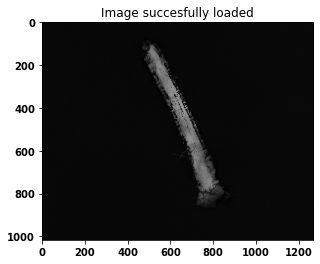

In [169]:
protein_LD = load_image("./data/AB42-SYN images/(Alpha-syn)(U3)(633 Region 010)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_LD)

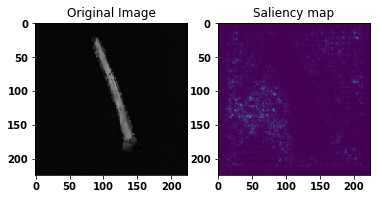

In [170]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_1,0)

(-0.5, 223.5, 223.5, -0.5)

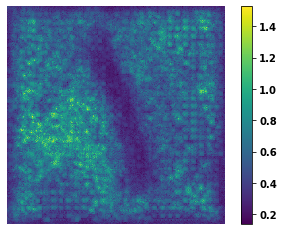

In [171]:
nout = np.power(sal_map, 0.2)

plt.imshow(nout)
plt.colorbar()
plt.axis('off') 
#plt.savefig('.\Result data\LR\Saliency map alpha-syn LR1.png')

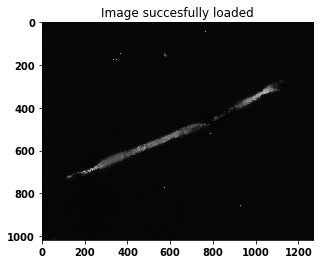

In [183]:
protein_LR = load_image("./data/AB42-SYN images/(AB-42)(S1)(Region 004)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_LR)

In [184]:
predict(protein_2_normal)

('0', 'Alpha-syn')

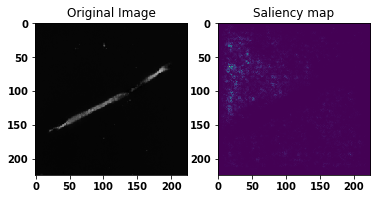

In [185]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_1,1)

(-0.5, 223.5, 223.5, -0.5)

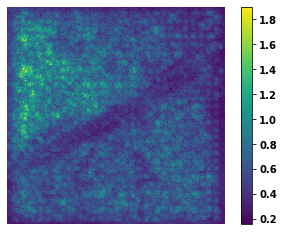

In [186]:
nout = np.power(sal_map, 0.2)

plt.imshow(nout)
plt.colorbar()
plt.axis('off') 
#plt.savefig('.\Result data\LR\Saliency map AB-42 LR1.png')

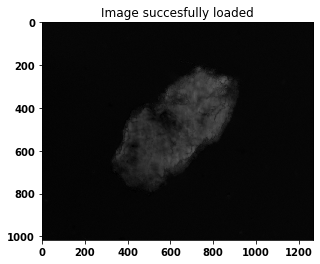

In [203]:
protein_LR = load_image("./data/AB42-SYN images/(AB-42)(S1)(Region 030)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_LR)

In [204]:
predict(protein_2_normal)

('1', 'AB-42')

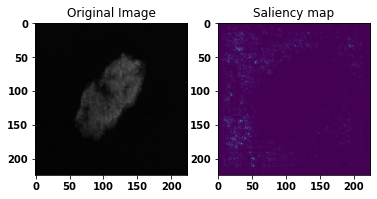

In [205]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_1,1)

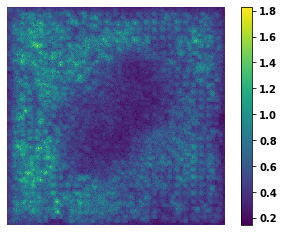

In [207]:
nout = np.power(sal_map, 0.2)

plt.imshow(nout)
plt.colorbar()
plt.axis('off') 
plt.savefig('.\Result data\LR\Saliency map AB-42 LR2.png')

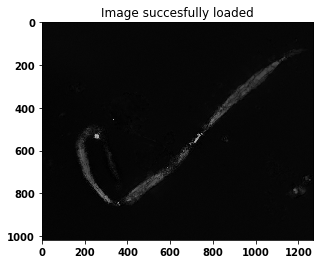

In [195]:
protein_LD = load_image("./data/AB42-SYN images/(Alpha-syn)(S1)(Region 032)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_LD)

In [196]:
predict(protein_2_normal)

('0', 'Alpha-syn')

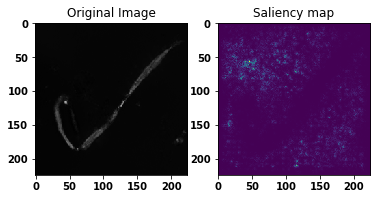

In [197]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_1,0)

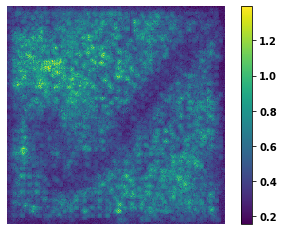

In [198]:
nout = np.power(sal_map, 0.2)

plt.imshow(nout)
plt.colorbar()
plt.axis('off') 
plt.savefig('.\Result data\LR\Saliency map alpha-syn LR3.png')

# LD images 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_6, train_acc_LD, train_loss_LD, test_acc_LD, test_loss_LD = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=100)

Epoch 099
----------
Train Loss:  0.6927 Acc:  0.5119
Epoch 199
----------
Train Loss:  0.6899 Acc:  0.5317
Epoch 299
----------
Train Loss:  0.6420 Acc:  0.6786
Epoch 399
----------
Train Loss:  0.5840 Acc:  0.7341
Epoch 499
----------
Train Loss:  0.5725 Acc:  0.6865
Epoch 599
----------
Train Loss:  0.5968 Acc:  0.6944
Epoch 699
----------
Train Loss:  0.3944 Acc:  0.8214
Epoch 799
----------
Train Loss:  0.6299 Acc:  0.7024
Epoch 899
----------
Train Loss:  0.4789 Acc:  0.7976
Epoch 999
----------
Train Loss:  0.4830 Acc:  0.7897
Epoch 1099
----------
Train Loss:  0.3655 Acc:  0.8571
Epoch 1199
----------
Train Loss:  0.2722 Acc:  0.8889
Epoch 1299
----------
Train Loss:  0.4012 Acc:  0.8571
Epoch 1399
----------
Train Loss:  0.2245 Acc:  0.9405
Epoch 1499
----------
Train Loss:  0.3185 Acc:  0.8810
Epoch 1599
----------
Train Loss:  0.2311 Acc:  0.9325
Epoch 1699
----------
Train Loss:  0.1651 Acc:  0.9484
Epoch 1799
----------
Train Loss:  0.4011 Acc:  0.8571
Epoch 1899
---------

In [10]:
_,acc_train_6 = test(resnet101_AB42_SYN_6,train_loader)
acc_train_6

tensor(1., device='cuda:0', dtype=torch.float64)

In [11]:
_,acc_test_6 = test(resnet101_AB42_SYN_6)
acc_test_6

tensor(0.7639, device='cuda:0', dtype=torch.float64)

In [12]:
_,acc_val_6 = test(resnet101_AB42_SYN_6,val_loader)
acc_val_6

tensor(0.7778, device='cuda:0', dtype=torch.float64)

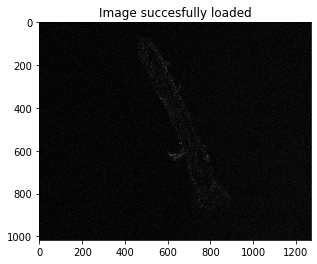

In [19]:
protein_LD = load_image("./data/AB42-SYN LD images/(Alpha-syn)(U3)(633 Region 010)(RS1)(PS1)(Diattenuation Lin).png")
protein_2_normal = normalize(protein_LD)

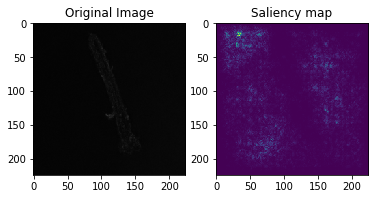

In [20]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_6,0)

In [56]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'bold'

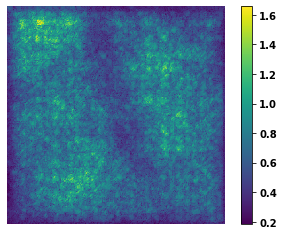

In [62]:
nout = np.power(sal_map, 0.2)

plt.imshow(nout)
plt.colorbar()
plt.axis('off') 
plt.savefig('Saliency map alpha-syn LD.png')

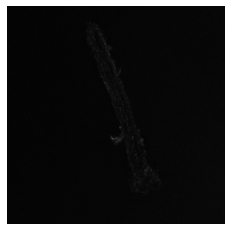

In [65]:
plt.imshow(true_image.cpu())
plt.axis('off') 

plt.savefig('LD image alpha-syn.png')

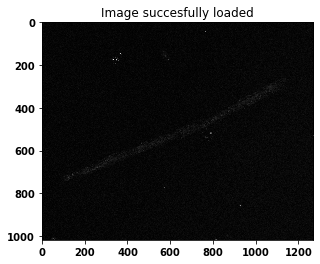

In [138]:
protein_LD = load_image("./data/AB42-SYN LD images/(AB-42)(S1)(Region 004)(RS1)(PS1)(Diattenuation Lin).png")
protein_2_normal = normalize(protein_LD)

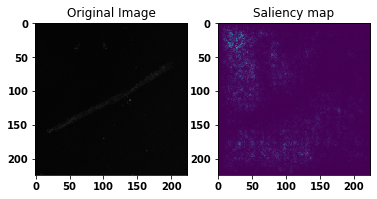

In [139]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_6,1)

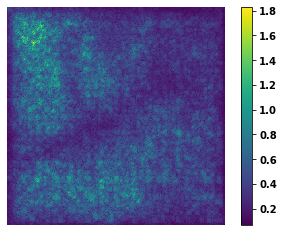

In [140]:
nout = np.power(sal_map, 0.3)

plt.imshow(nout)
plt.colorbar()
plt.axis('off') 
plt.savefig('Saliency map AB-42 LD1.png')

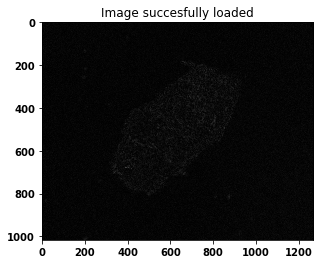

In [208]:
protein_LD = load_image("./data/AB42-SYN LD images/(AB-42)(S1)(Region 030)(RS1)(PS1)(Diattenuation Lin).png")
protein_2_normal = normalize(protein_LD)

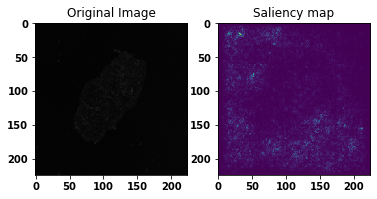

In [209]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_6,1)

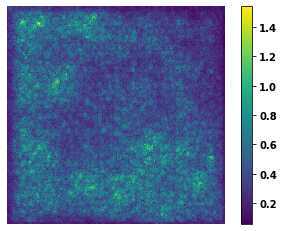

In [217]:
nout = np.power(sal_map, 0.3)

plt.imshow(nout)
plt.colorbar()
plt.axis('off') 
plt.savefig('./Result data/LD/Saliency map AB-42 LD2.png')

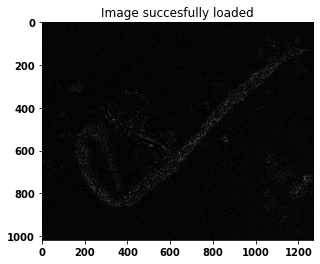

In [130]:
protein_LD = load_image("./data/AB42-SYN LD images/(Alpha-syn)(S1)(Region 032)(RS1)(PS1)(Diattenuation Lin).png")
protein_2_normal = normalize(protein_LD)

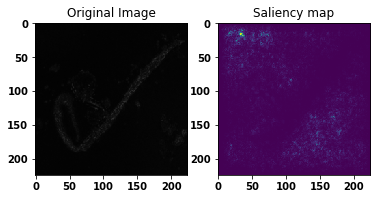

In [131]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_6,0)

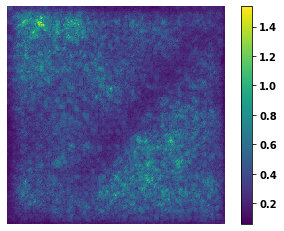

In [133]:
nout = np.power(sal_map, 0.3)

plt.imshow(nout)
plt.colorbar()
plt.axis('off') 
plt.savefig('./Result data/LD/Saliency map alpha-syn LD3.png')

# Save variable 

In [45]:
from numpy import savetxt

In [47]:
savetxt('LD sal map.csv',nout,delimiter=',')

In [48]:
import scipy.io as sio

In [54]:
sio.savemat("train_acc_LD.mat", mdict={'train_acc_LD':train_acc_LD})
sio.savemat("test_acc_LD.mat", mdict={'test_acc_LD':test_acc_LD})

In [55]:
sio.savemat("train_loss_LD.mat", mdict={'train_loss_LD':train_loss_LD})
sio.savemat("test_loss_LD.mat", mdict={'test_loss_LD':test_loss_LD})

In [61]:
torch.save(resnet101_AB42_SYN_6.state_dict(), r'C:\Users\y63qiu\PycharmProjects\Pure protein project\Result data\resnet_LD.pt')

In [151]:
sio.savemat("train_acc_LR.mat", mdict={'train_acc_LR':train_acc_LD})
sio.savemat("test_acc_LR.mat", mdict={'test_acc_LR':test_acc_LD})
sio.savemat("train_loss_LR.mat", mdict={'train_loss_LR':train_loss_LD})
sio.savemat("test_loss_LR.mat", mdict={'test_loss_LR':test_loss_LD})

In [152]:
torch.save(resnet101_AB42_SYN_1.state_dict(), r'C:\Users\y63qiu\PycharmProjects\Pure protein project\Result data\resnet_LR.pt')